# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data analysis

In [3]:
azdias.shape

(891221, 366)

In [4]:
missing_values_count = azdias.isnull().sum()
print(missing_values_count)

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [7]:
#Find out if it is possible to use LNR variable to label customers in general population
list_customers = list(customers['LNR'])
list_azdias = list(azdias['LNR'])

In [8]:
def intersect_list(list1, list2):
    '''
    INPUT
    list1 - first list
    list2 - second list
    
    OUTPUT
    int_list - intersecting list
    '''
    return list(set(list1) & set(list2))


In [9]:
list_int_indv = list(set(customers['LNR']) & set(azdias['LNR']))
count_int_indv = len(list_int_indv)
print(count_int_indv)

0


In [10]:
azdias_subset = azdias.sample(n = 200000, replace = True)
customers_subset = customers.sample(n = 43000, replace = True )

In [11]:
azdias_subset = azdias_subset.assign(Cust_Ind='General')
customers_subset = customers_subset.assign(Cust_Ind='Customer')


In [12]:
cust_ind_counts  = azdias_subset['Cust_Ind'].value_counts()
print(cust_ind_counts)

General    200000
Name: Cust_Ind, dtype: int64


In [13]:
customers_counts  = customers_subset['Cust_Ind'].value_counts()
print(customers_counts)

Customer    43000
Name: Cust_Ind, dtype: int64


In [14]:
customer_group_counts = customers_subset['CUSTOMER_GROUP'].value_counts()
print(customer_group_counts)

MULTI_BUYER     29434
SINGLE_BUYER    13566
Name: CUSTOMER_GROUP, dtype: int64


In [15]:
product_group_counts = customers_subset['PRODUCT_GROUP'].value_counts()
print(product_group_counts)

COSMETIC_AND_FOOD    22391
FOOD                 10776
COSMETIC              9833
Name: PRODUCT_GROUP, dtype: int64


In [16]:
online_purchase_counts = customers_subset['ONLINE_PURCHASE'].value_counts()
print(online_purchase_counts)

0    39181
1     3819
Name: ONLINE_PURCHASE, dtype: int64


In [17]:
df_agg = pd.concat([azdias_subset, customers_subset], sort=False)
df_agg['Cust_Ind'].value_counts()

General     200000
Customer     43000
Name: Cust_Ind, dtype: int64

In [18]:
#number of missing values by each column in azdias dataset
col_nul_percent=azdias.isnull().sum()/azdias.shape[0]

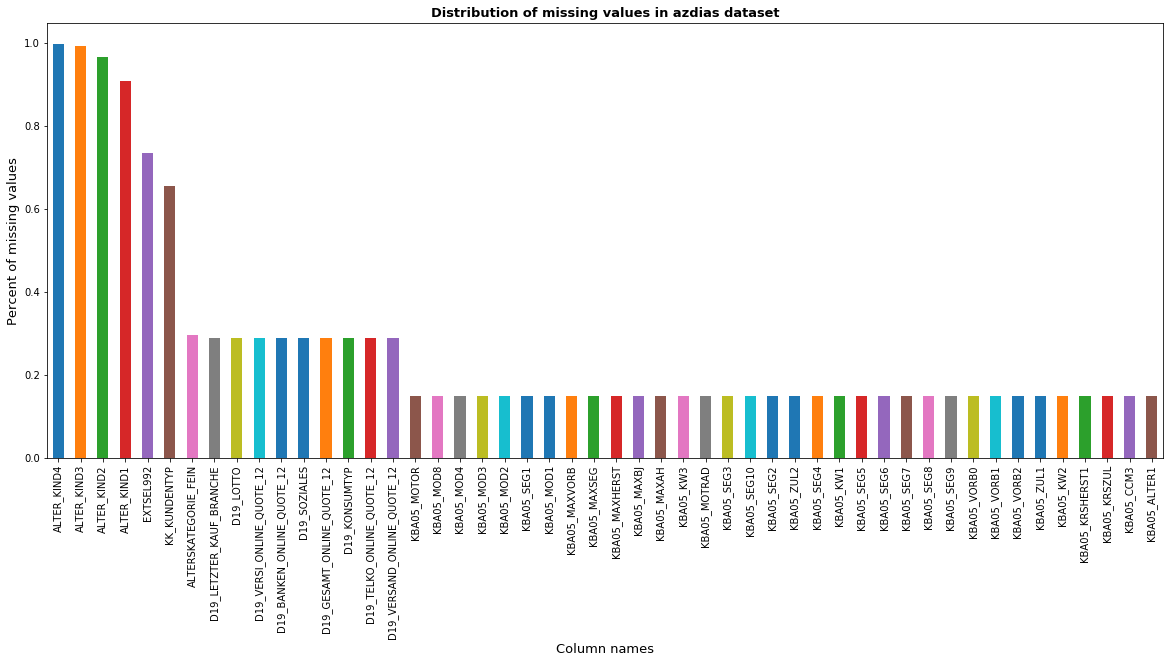

In [19]:
# Tamaño de la figura del gráfico
plt.figure(figsize=(20, 8))  
# Crear un gráfico de barras con los 50 primeros valores de porcentaje de valores perdidos
col_nul_percent.sort_values(ascending=False)[:50].plot(kind='bar') 
plt.title("Distribution of missing values in azdias dataset", fontsize=13, fontweight="bold")  # Título del gráfico
plt.xlabel("Column names", fontsize=13)  # Etiqueta del eje x
plt.ylabel("Percent of missing values", fontsize=13)  # Etiqueta del eje y
plt.xticks(rotation=90)  # Rotación de los nombres de las columnas en el eje x
plt.show()  # Mostrar el gráfico



In [20]:
#Distribution of missing values by columns:-
missing_by_col=azdias.isnull().sum()/azdias.shape[0]  

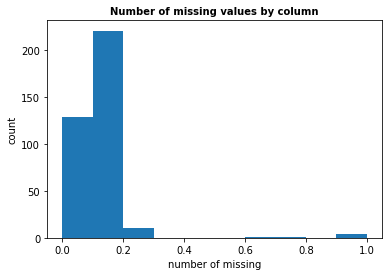

In [21]:
# Histograma de valores faltantes por columna
plt.hist(missing_by_col)

# Título del gráfico
plt.title("Number of missing values by column", fontsize=10, fontweight="bold")

# Etiqueta del eje x
plt.xlabel("number of missing", fontsize=10)

# Etiqueta del eje y
plt.ylabel("count", fontsize=10)

# Mostrar el gráfico
plt.show()



In [22]:
#Distribution of missing values by rows:-
row_nul_percent=azdias.isnull().sum(axis=1)  

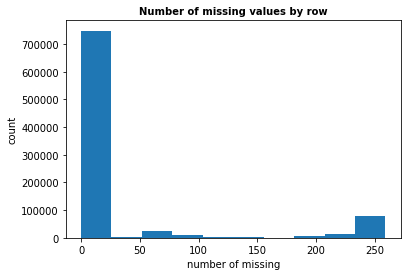

In [23]:
# Histograma del porcentaje de valores faltantes por fila
plt.hist(row_nul_percent)

# Título del gráfico
plt.title("Number of missing values by row", fontsize=10, fontweight="bold")

# Etiqueta del eje x
plt.xlabel("number of missing", fontsize=10)

# Etiqueta del eje y
plt.ylabel("count", fontsize=10)

# Mostrar el gráfico
plt.show()


In [24]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe that will be cleaned
    
    OUTPUT
    new_df - new pandas dataframe after cleaning
    '''
    #List to keep track of columns with problems
    prob_col_list = []
    #Fill missing values of working class variable
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].fillna(0)
    for column in df:
        #Remove columns with more than 15% missing values
        if df[column].isnull().sum() > (df.shape[0]*0.15):
            df.drop(columns = [column], inplace = True)
        else:
            try:
                #fill in missing values with mean of the corresponding working class the individual is in
                df[column] = df.groupby('CAMEO_DEUG_2015')[column].transform(lambda x: x.fillna(x.mean())).round(0)            
                df[column] = df[column].astype(str).str.replace('XX', '').astype(float).round(0).astype(int)
            except:
                try:
                    df[column] = df[column].astype(str).str.replace('X', '0').astype(float).round(0).astype(int)
                except:
                        try:
                            df[column] = df[column].fillna(0).astype(str).str.replace('XX', '0').astype(float).round(0).astype(int)
                        except:
                            prob_col_list.append(column)
                
    try:
        prob_col_list.append('CAMEO_DEU_2015')
    except:
        try: 
            prob_col_list.remove('CUSTOMER_GROUP')
            prob_col_list.remove('PRODUCT_GROUP')
        except:
            pass
    
    try:
        prob_col_list.remove('Cust_Ind')
    except:
        pass

    df_new = df[df.columns.difference(prob_col_list)]
    
    return df_new, prob_col_list

In [25]:
df_clean_agg, prob_col_list = clean_data(df_agg)


In [26]:
df_clean_cust, prob_cust_col_list = clean_data(customers_subset)

In [27]:
#Only use columns where customer dataset possess high quality data
list_agg_col = list(df_clean_agg.columns)
list_cust_col = list(df_clean_cust.columns)
list_int_col = intersect_list(list_agg_col, list_cust_col)

In [28]:
df_clean_agg = df_clean_agg[list_int_col]

In [29]:
df_clean_agg.shape

(243000, 115)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [30]:
# Crear etiquetas para distinguir entre los datos de la población general y los clientes
y_cust = df_clean_agg['Cust_Ind']

# Eliminar la columna 'Cust_Ind' para obtener las características de los clientes
X_cust = df_clean_agg.drop(columns=['Cust_Ind'])


In [31]:
def scale_features(df):
    '''
    INPUT
    df - pandas dataframe numérico que se escalará
    
    OUTPUT
    X_scaled - matriz de valores escalados
    '''

    # Obtener los valores del DataFrame
    X = df.values

    # Escalar los valores utilizando StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled


In [32]:
X_cust_scaled = scale_features(X_cust)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


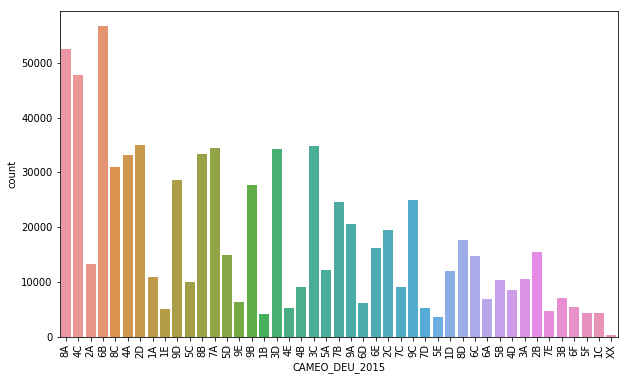

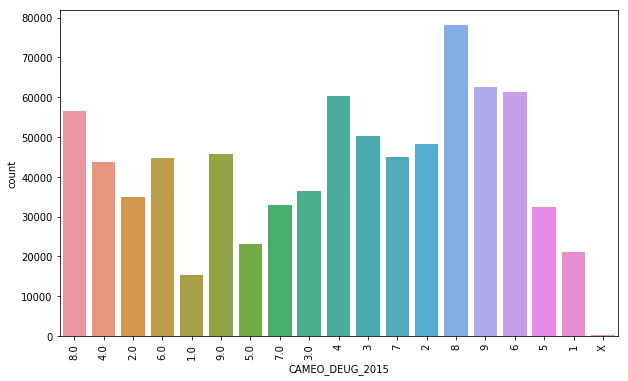

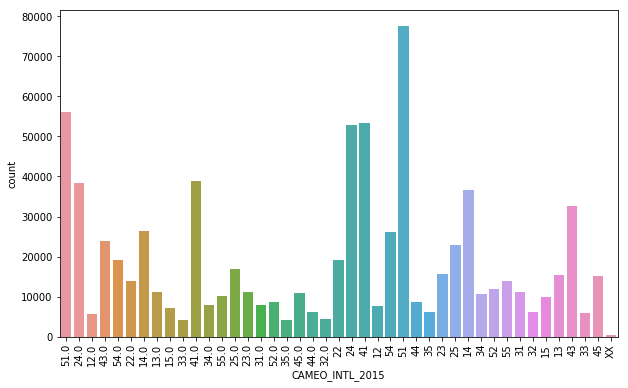

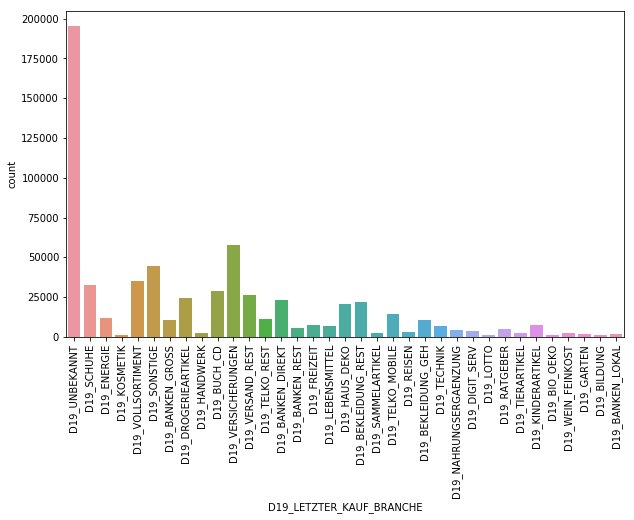

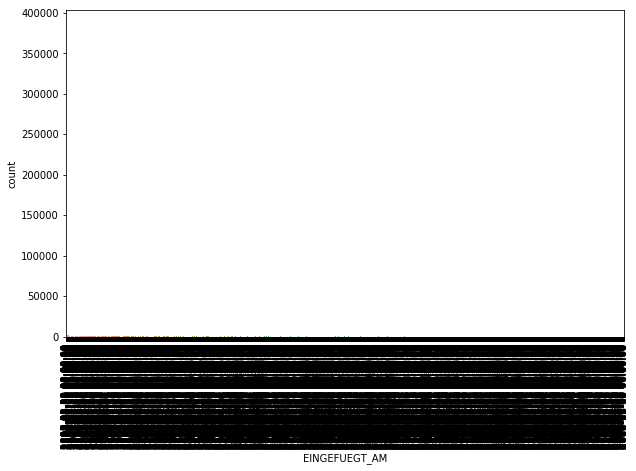

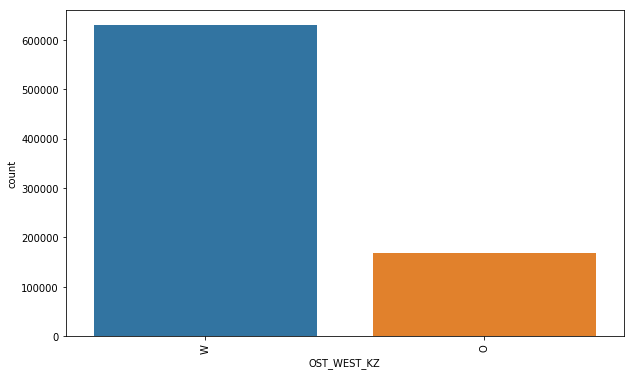

In [33]:
categorical_cols = azdias.select_dtypes(include=['object']).columns

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=azdias)
    plt.xticks(rotation=90)
    plt.show()


In [34]:
def corr_features(df):
    '''
    INPUT
    df - pandas dataframe numérico en el cual se creará una matriz de correlación
    
    OUTPUT
    Un gráfico de matriz de correlación de las características con colores pastel y bordes negros
    '''
    
    # Crear una figura y un eje para el gráfico
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Título del gráfico
    plt.title('Correlation of Features')
    
    # Crear la matriz de correlación 
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(df.iloc[:, :15].corr(), linewidths=0.2, vmax=1, square=True, linecolor='black', annot=True, cmap=cmap)
    
    # Mostrar el gráfico
    plt.show()


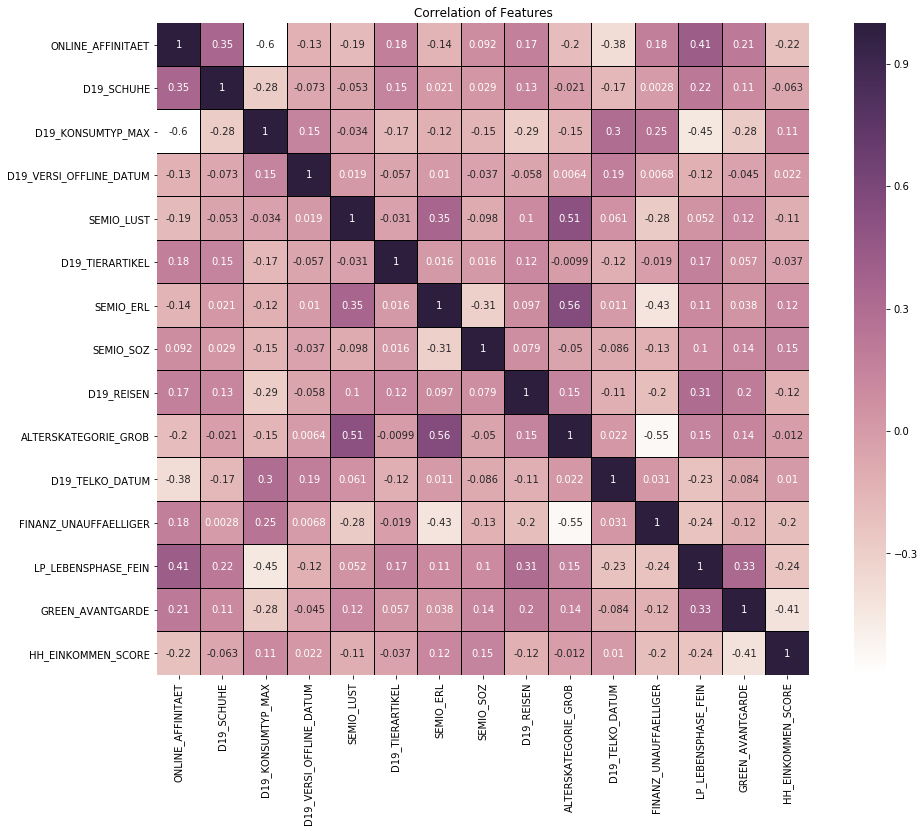

In [35]:
corr_features(X_cust)

In [36]:
def gen_eigval_eig_vec(num_array):
    '''
    INPUT
    num_array - matriz numérica de la cual se generarán los valores y vectores propios
    
    OUTPUT
    eig_val - arreglo de valores propios
    eig_vec - arreglo de vectores propios
    '''
    
    # Calcular la media de la matriz numérica
    mean = np.mean(num_array, axis=0)
    
    # Calcular la matriz de covarianza de la matriz numérica
    cov_mat = np.cov(num_array, rowvar=False)
    
    # Calcular los valores y vectores propios de la matriz de covarianza
    eig_val, eig_vec = np.linalg.eig(cov_mat)
    
    return eig_val, eig_vec

eig_val, eig_vec = gen_eigval_eig_vec(X_cust_scaled)


In [37]:
def order_plot_expl_var(eig_val, eig_vec, plot=True):
    '''
    INPUT
    eig_val - arreglo de valores propios
    eig_vec - arreglo de vectores propios
    plot - booleano que indica si se debe crear un gráfico
    
    OUTPUT
    eig_tups - tupla de valores y vectores propios ordenados
    (Opcional) gráfico de la varianza explicada
    '''
    
    # Crear tuplas ordenadas de valores y vectores propios
    eig_tups = [(np.abs(eig_val[i]), eig_vec[:, i]) for i in range(len(eig_val))]
    eig_tups.sort(key=lambda x: x[0], reverse=True)
    
    # Calcular la proporción de varianza explicada y la varianza acumulada
    tot_var = np.sum(eig_val)
    var_expl = [i / tot_var for i in sorted(eig_val, reverse=True)]
    cum_var = np.cumsum(var_expl)
    
    if plot:
        # Crear gráfico de las componentes principales más importantes
        plt.figure(figsize=(10, 5))
        plt.title('Most important Principal components')
        plt.xlabel('Principal Components')
        plt.ylabel('Proportion of variance explained')
        plt.bar(range(len(eig_val)), var_expl, color='r', label='Principal Component')
        plt.step(range(len(eig_val)), cum_var, label='Cumulative variance explained')
        plt.legend(loc='best')
        plt.show()
        
    print('Eigen Values in descending order: \n')
    for tup in eig_tups:
        print(tup[0])
        
    return eig_tups


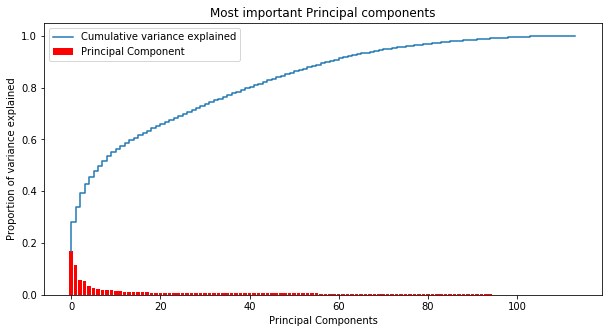

Eigen Values in descending order: 

19.0869581612
13.1505062143
6.55670150844
6.16550988879
3.91147458497
3.00863707162
2.63410896531
2.31503513349
2.19343986034
1.98536623225
1.69471929634
1.48247621583
1.40177007262
1.27996678523
1.20154569668
1.10987788611
1.07698747706
1.01719149061
1.00062409699
0.98304263585
0.968413829012
0.948924755196
0.943822164379
0.928210365202
0.913467885014
0.899313396893
0.883425290247
0.875421417585
0.861149160502
0.848597317425
0.842848054771
0.826502781029
0.814569830511
0.806304143575
0.792566172837
0.789486913574
0.75850403854
0.753187727043
0.742282951937
0.73446575955
0.728949606175
0.716577525714
0.713571558737
0.704879585784
0.694453963795
0.682226543368
0.675583245256
0.672039193362
0.662666798541
0.65675835257
0.647517809167
0.640767178184
0.634475221033
0.624783499029
0.606430393172
0.596032255963
0.570208105567
0.55518077311
0.545469756248
0.524607639868
0.52244824471
0.516625789099
0.503271347118
0.458109774671
0.435932632148
0.433014989673

In [38]:
eig_tups = order_plot_expl_var(eig_val, eig_vec)

In [39]:
def create_matrix_w(df, eig_tups, frac_of_feat):
    '''
    INPUT
    df - dataframe de pandas en el cual se creará la matriz
    eig_tups - tuplas de valores y vectores propios
    frac_of_feat - fracción de características a utilizar
    
    OUTPUT
    W - matriz de proyección que proyectará el espacio de n dimensiones a un subespacio de menor dimensión
    '''
    # Obtener el número de características a utilizar en función de la fracción especificada
    num_features = int(df.shape[1] * frac_of_feat)
    
    # Concatenar los vectores propios seleccionados en una matriz de proyección W
    W = np.hstack([eig_tups[i][1].reshape(-1, 1) for i in range(num_features)])
    
    return W

W = create_matrix_w(df_clean_agg, eig_tups, 0.1)

In [40]:
Y = X_cust_scaled.dot(W)

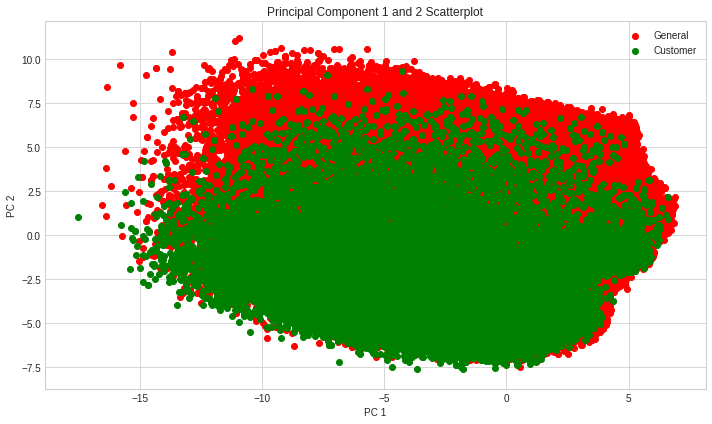

In [41]:
def create_PC_scatter(Y, y_lab):
    '''
    INPUT
    Y - Valores de los datos escalados proyectados en el subespacio
    y_lab - Variable para etiquetar el diagrama de dispersión
    
    OUTPUT
    Diagrama de dispersión de Y con etiquetas de "General Public" y "Customer"
    '''

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 6))
        
        # Iterar sobre las etiquetas ("General", "Customer") y los colores correspondientes
        for lab, col in zip(('General', 'Customer'), ('red', 'green')):
            # Crear el diagrama de dispersión para cada etiqueta
            plt.scatter(Y[y_lab==lab, 0],
                        Y[y_lab==lab, 1],
                        label=lab,
                        c=col)
        
        # Establecer etiquetas de ejes y título del gráfico
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        plt.title('Principal Component 1 and 2 Scatterplot')
        
        # Mostrar la leyenda y ajustar el diseño del gráfico
        plt.legend(loc='best')
        plt.tight_layout()
        
        # Mostrar el diagrama de dispersión
        plt.show()

create_PC_scatter(Y, y_cust)


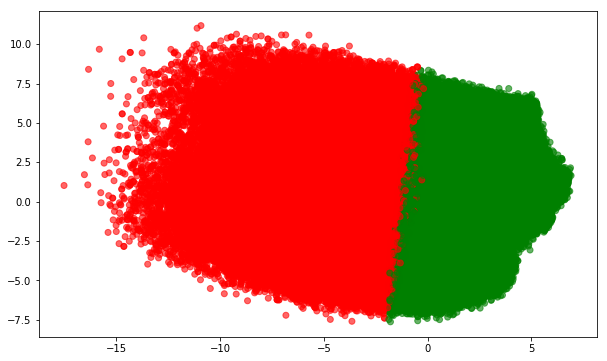

In [42]:
def setup_and_plt_kmeans(Y, n_clust):
    '''
    INPUT
    Y - Valores proyectados de las características escaladas
    n_clust - el número de clústeres
    
    OUTPUT
    Gráfico de K-means
    '''

    # Crear una instancia de KMeans con el número de clústeres especificado
    kmeans = KMeans(n_clusters=n_clust)
    
    # Aplicar K-means y asignar etiquetas a los puntos de datos proyectados
    X_clust = kmeans.fit_predict(Y)
    
    # Mapeo de colores de etiquetas a colores reales
    LABEL_COLOR_MAP = {0: 'r', 1: 'g'}
    label_color = [LABEL_COLOR_MAP[i] for i in X_clust]

    # Graficar el diagrama de dispersión
    plt.figure(figsize=(10, 6))
    plt.scatter(Y[:, 0], Y[:, 1], c=label_color, alpha=0.6)
    plt.show()
    
setup_and_plt_kmeans(Y, 2)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [43]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
def clean_train_df(df):
    '''
    INPUT
    df - pandas dataframe que se limpiará
    
    OUTPUT
    clean_df - pandas dataframe limpio
    '''
    
    # Limpieza de los datos y obtención de clean_df y prob_list_train
    clean_df, prob_list_train = clean_data(df)
    
    # Obtención de Y_train y X_train a partir de clean_df
    Y_train = clean_df['RESPONSE'].values
    X_train = clean_df.drop(columns=['RESPONSE'])
    
    return Y_train, X_train


In [45]:
Y_train, X_train = clean_train_df(mailout_train)

In [46]:
#scale features
X_train_scaled = scale_features(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


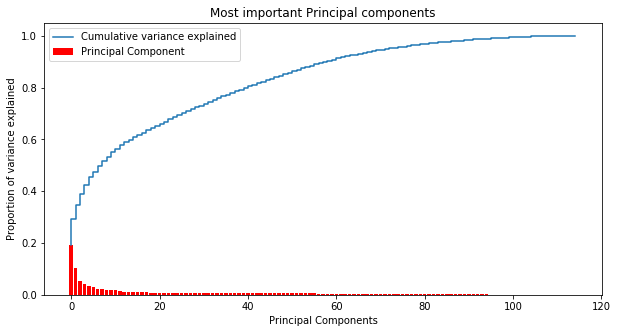

Eigen Values in descending order: 

21.9578723397
11.8662394312
6.08628315746
4.83439457561
4.08742514846
3.44069062349
2.44924458958
2.38083899189
2.22164722225
2.06407666525
1.99164019938
1.59999655062
1.41727673167
1.27119937977
1.15561998634
1.1183531388
1.0560340874
1.03595681893
1.01358794882
1.00108406295
0.995143862528
0.97333182661
0.966490163622
0.943727544641
0.930538496933
0.911773166187
0.887675284899
0.875698375574
0.860457010936
0.858641903618
0.838645270102
0.823464578827
0.812899708805
0.810753337151
0.793772434934
0.774723394757
0.767035125016
0.762953957959
0.758735170252
0.738007497459
0.728394834296
0.726177440528
0.719368797266
0.707745494227
0.694522699417
0.687643365689
0.680965017171
0.677319230689
0.664939463779
0.660241715566
0.654010558149
0.640369744744
0.628676249075
0.619542866803
0.600894965909
0.59206634958
0.569680019766
0.567954812471
0.529460668086
0.518061495275
0.506258217766
0.497621259277
0.482181577088
0.453909380536
0.411335438741
0.39898566387

In [47]:
eig_val_train, eig_vec_train = gen_eigval_eig_vec(X_train_scaled)
eig_tups_train = order_plot_expl_var(eig_val_train, eig_vec_train)


In [48]:
W_train = create_matrix_w(mailout_train, eig_tups_train, 0.8)
W_train.shape

(115, 92)

In [49]:
#Project dataset to a lower dimension
X_proj_train = X_train_scaled.dot(W_train)

In [50]:
#intialize Logistic Regression and train data
lr = LogisticRegression()
lr.fit(X_proj_train, Y_train);

In [51]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
clean_test_df, prob_list_test = clean_data(mailout_test)

In [53]:
#scale features
X_test_scaled = scale_features(clean_test_df)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


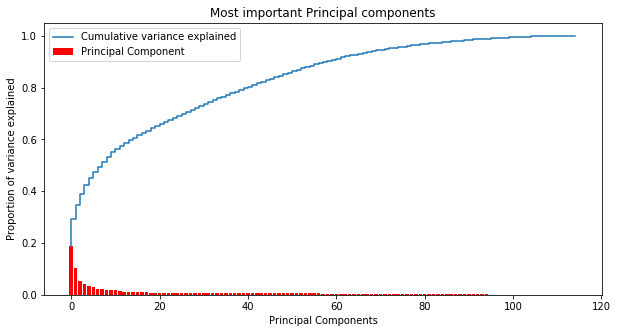

Eigen Values in descending order: 

21.8132586321
11.7870725074
6.12507374038
4.86540567696
4.06157575648
3.43926577956
2.46096304419
2.3841649409
2.22000484019
2.05228140354
2.01715590793
1.61409113982
1.41107921805
1.27650385477
1.15212579884
1.10624531193
1.06168305387
1.05233926466
1.00915907535
0.997305782588
0.994755589016
0.970202612911
0.961370247963
0.951513608311
0.930003440121
0.916128543736
0.883123466457
0.873864788575
0.868413685431
0.860732887815
0.855130965466
0.833870600558
0.824465757051
0.816292485753
0.78532925244
0.780250644626
0.768274407221
0.762908566963
0.759123958694
0.748888183281
0.736507903179
0.729274854891
0.721239787027
0.702275586349
0.698408262406
0.68313526854
0.676553290237
0.672105704893
0.665717458936
0.659018186674
0.650356951541
0.644028467584
0.641359449454
0.629290423337
0.602822665244
0.583925935892
0.58195319083
0.554287133005
0.533287058591
0.522128799819
0.520023221296
0.500212639082
0.485857122009
0.46063012566
0.413792706591
0.40628716671

In [54]:
#compute eigen values and vectors
eig_val_test, eig_vec_test = gen_eigval_eig_vec(X_test_scaled)
eig_tups_test = order_plot_expl_var(eig_val_test, eig_vec_test)

In [63]:
#Create projection matrix
W_test = create_matrix_w(mailout_train, eig_tups_test, 0.8)

In [64]:
W_test.shape

(115, 92)

In [65]:
#Project dataset to a lower dimension
X_proj_test = X_test_scaled.dot(W_test)

In [66]:
#Predict probabilities
Y_pred = lr.predict_proba(X_proj_test)

In [67]:
Y_pred_df = pd.DataFrame(Y_pred)

In [68]:
Y_pred_cust_df = Y_pred_df[1]

In [69]:
list_Y_pred_cust = list(Y_pred_cust_df)